# Collateral Shortfall Monitoring

For more context and definitions around collateral shortfall monitoring, [check out our article on atoti.io](https://www.atoti.io/rapid-collateral-modelling-and-simulation-with-atoti/).

### Introduction

In this notebook, we will showcase how quickly a dashboard can be put together for a simplified use case of Collateral Shortfall monitoring with atoti libraries.  
  
Collateral is a form of credit risk mitigation where an asset is accepted as security for extending a loan.  
Market value of a collateral changes over time and lender has to accomodate for it. As such, depending on the amount of risk associated, a percentage of what is known as haircut is applied to the asset's market value. This gives the value of the collateral that can be used for loan, also known as collateral value.   
  
Collateral Shortfall occurs when the collateral value goes below the cash out value. That meant that the value of collateral is less than what it is expected to be, due to a variety of factors such as market fluctuations, contracts enforceability etc. 

We will be creating a multi-dimension data cube and derive the various measures such as market value, collateral value after haircut, cash out value over account and thereafter, the Collateral shortfall for the accounts. 

Leveraging on the data cube and atoti's data visualization, we will put together dashboards that reflects collateral status of accounts. Cherry on top, we will perform some *What if Analysis* to demonstrate the impact on Collateral in the below scenarios:  

- Haircut simulation where there is a consumption slowdown in the Consumer Cyclical sector in Italy and France
- Technology slump where price value for the sector dipped by 30%
- Cash out simulation where cash out increase by 10%

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=collateral-monitoring" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

#### Dependencies

As data used in this notebook is stored on AWS S3, hence it is necessary to install the [atoti-aws plugin](https://docs.atoti.io/latest/plugins.html#available-plugins).

```
!pip install atoti-aws
or 
!conda install atoti-aws
```

In [1]:
import atoti as tt
import pandas as pd
import numpy as np
import os
from natsort import natsorted
from tabulate import tabulate
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
import utils

Welcome to atoti 0.6.4!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, set the ATOTI_DISABLE_TELEMETRY environment variable to True.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [2]:
# a session has to be created for atoti
# dashboards are persisted in the content storage
session = tt.create_session(config={"user_content_storage": "content"})

### Data loading
A session is used to read data of formats csv, parquet, pandas dataframe, numpy and spark.   
Refer to https://docs.atoti.io/0.3.1/tutorial/08-data-sources.html 
   
#### Loading csv

In [3]:
asset_positions_table = session.read_csv(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_positions.csv",
    keys=["Account", "Asset_Code"],
    table_name="asset_positions",
)

In [4]:
# use table.head(n) preview the first n rows loaded into the table where needed
# likewise, you can use table.columns to preview the columns in the table
# or {"columns": len(table.columns), "rows": len(table)} to see the number of rows and columns loaded into the table
asset_positions_table.head()

Quantity
Account           Asset_Code          
Niel              CAP.PA      100000.0
                  SAN.PA      100000.0
Musk              ENI.PA      100000.0
                  ENGI.PA     100000.0
Bezos & MacKenzie AC.PA       100000.0

### Loading parquet

In [5]:
assets_table = session.read_parquet(
    "s3://data.atoti.io/notebooks/collateral-shortfall-monitoring/assets_attributes.parquet",
    keys=["Asset_Code"],
    table_name="assets",
)

assets_table.head()

,Sector,Country,Haircut
Asset_Code,,,
BNP.PA,Financial Services,France,0.1
CA.PA,Consumer Defensive,France,0.1
AC.PA,Consumer Cyclical,France,0.1
ENGI.PA,Utilities,France,0.1
CAP.PA,Technology,France,0.1


### Loading csv via pandas before session loads pandas dataframe   
Being able to load pandas dataframe gives us the flexibility to manipulate dataframe before loading them or later on when we do simulations.

In [6]:
assets_prices_df = pd.read_csv(os.path.join("../data", "assets_prices.csv"))

In [7]:
assets_prices_table = session.read_pandas(
    assets_prices_df,
    keys=["Asset_Code", "Date"],
    table_name="assets_prices",
)

In [8]:
assets_prices_table.head()

Price
Asset_Code Date                 
AC.PA      2021-04-08  33.180000
           2021-04-09  33.040001
           2021-04-10  32.890001
           2021-04-11  32.740000
           2021-04-12  32.590000

In [9]:
loans_positions_df = pd.read_csv(
    "http://data.atoti.io/notebooks/collateral-shortfall-monitoring/loans_positions.csv"
)

In [10]:
loans_positions_table = session.read_pandas(
    loans_positions_df, keys=["Account"], table_name="loans_positions"
)

In [11]:
loans_positions_table.head()

,Cash_Out
Account,
Bezos & MacKenzie,16000000.0
Buffet,54000000.0
Daniel Ek,9000000.0
Gates & Melinda,17000000.0
Musk,9000000.0


### Joining data table

In [12]:
asset_positions_table.join(assets_table, mapping={"Asset_Code": "Asset_Code"})

In [13]:
asset_positions_table.join(loans_positions_table, mapping={"Account": "Account"})

In [14]:
asset_positions_table.join(assets_prices_table, mapping={"Asset_Code": "Asset_Code"})

### Cube creation

In [15]:
cube = session.create_cube(asset_positions_table, "Collateral_Management")

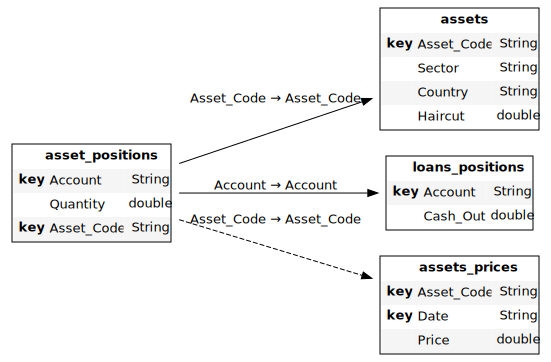

In [16]:
cube.schema

### Quick analysis with cube.visualize

In [17]:
# we can perform drill-down to different hierarchies in a pivot table
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [18]:
session.visualize("explore-dataset-using-pivot-table")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Cube structure
During cube creation, numeric values are automatically created as measures. Non numeric values are automatically translated to levels under hierarchy of the same name. This can be [configured](https://www.atoti.io/documentation/lib/atoti.html#atoti.session.Session.create_cube) differently.

In [19]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels

Before we proceed with the data aggregation aspects, let's inspect the hierarchies created

In [20]:
h

Hierarchies()

We are going to set the hierarchy *Date* as a slicing hierarchy. A slicing hierarchy will not aggregate the data on all its members.  
This means that we always view a subset of the cube by one date by default, which is usually what is needed.

In [21]:
h["Date"].slicing = True

In [22]:
m

Measures()

### Creating new measures  
From the data we have, we can derive the following:   
$Market Value = Price \times Quantity$  
$Collateral Value = Market Value \times (1 - Haircut)$   
  
The above measures are aggregated over the Account and Asset Code levels in order to compute the Collateral Shortfall at account level:  
$Collateral Shortfall = Collateral Value - Cash Out$   
Where Cash Out is also aggregated at account level           

In [23]:
m["Price"] = tt.value(assets_prices_table["Price"])

In [24]:
m["Market Value"] = tt.agg.sum(
    m["Price"] * m["Quantity.SUM"],
    scope=tt.scope.origin(lvl["Sector"], lvl["Country"], lvl["Account"]),
)

In [25]:
m["Haircut"] = tt.agg.sum(assets_table["Haircut"])

m["Collateral Value"] = tt.agg.sum(
    m["Price"] * m["Quantity.SUM"] * (1 - m["Haircut"]),
    scope=tt.scope.origin(lvl["Sector"], lvl["Country"]),
)

In [26]:
cash_out = tt.value(loans_positions_table["Cash_Out"])
m["Cash Out"] = tt.agg.sum(cash_out, scope=tt.scope.origin(lvl["Account"]))

In [27]:
m["Collateral Shortfall"] = m["Collateral Value"] - m["Cash Out"]

In [28]:
m

Measures()

Let's explore this new measures.

In [29]:
# we can look at the price.VALUE across Date, further split the charts by Asset_Code
session.visualize("times-series")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [30]:
# give a meaningful title to the visualization. This helps to reconcile the objective of the visual and also could be the title of
# the widget when visual is published
session.visualize("haircut-value")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Monitoring Collateral Shortfall  
We created a pivot table for with the Collateral Shortfall, Market Value, Cash Out and Collateral Value for Accounts.  
Negative Collateral Shortfall are highlighted in red. Feel free to click on the `>` to drill-down to other hierarchies such as Sector to account for the shortfall. 

In [31]:
session.visualize("Collateral Shortfall")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In view of all accounts, using a Gauge chart will show us that we are not yet in shortfall and how far we are from it.   
The red marker shows the total Market value, which is the maximum threshold before shortfall will occur.

In [32]:
session.visualize("total-cash-out")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Total Cash out Bank wide  
  
We can use a Tree map to visualize the asset concentration. A well diversified portfolio will help to reduce the collateral risks.

In [33]:
session.visualize("Asset Concentration")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## atoti UI and Dashboard creation
Until now, we have created a few visualizations. We can right-click on the visuals to publish them as widgets.
These widgets can then be used to build a dashboard.  

<img src="http://data.atoti.io/notebooks/collateral-shortfall-monitoring/collateral_dashboard.gif" alt="collateral_dashboard" style="zoom:40%;" />

In [34]:
session.link(path="#/dashboard/3a7")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Click on the URL above to view the dashboard that was prepared. We can use the quick filter to select an account for viewing.  
We can also do a right-click drillthrough to investigate the underlying data.  
  
To play with the UI and explore the data, [you can have a look at our UI documentation here](https://www.activeviam.com/activeui/documentation/index.html).

## Simulations
Now that we have basic monitoring on Collateral Shortfall, we can do some simulations in the data cube.

### Setup Price Simulation

The two kinds of simulation in atoti are:

- Measure simulation
- Source simulation

In Measure simulations, we modify the value of the measures in scenarios of the simulations without duplicating data.  
Source simulation on the other hand, is a simulation created by loading a new source of modified data to the cube.

Here, we will use the Source simulation to simulate variations of the price by considering the price forecast at the following different time horizons:

- 1 day
- 3 days
- 1 week

For each forecasting time horizon, we will predict the Collateral Shortfall.

First, let's load the price forecast tables in a unique table.

In [35]:
files = [
    os.path.join("../results/predictions", f)
    for f in os.listdir("../results/predictions")
    if ".csv" in f
]
price_predictions_df = pd.DataFrame()

for f in files:
    price_predictions_df = pd.concat(
        [price_predictions_df, pd.read_csv(f, index_col=0)]
    )
price_predictions_df = price_predictions_df.sort_index()

In [36]:
dic = {
    "PLS Prediction": ["CAP.PA"],
    "O-PLS Prediction": ["RACE.MI"],
    "XGBoost Prediction": ["AC.PA", "ENGI.PA", "G.MI", "TIT.MI"],
    "Augmented XGBoost Prediction": ["BNP.PA", "SAN.PA"],
}

best_model = {v: key for key, values in dic.items() for v in values}
best_model = {k: best_model[k] for k in natsorted(best_model.keys())}

In [37]:
price_predictions_df["Best Model"] = price_predictions_df.apply(
    lambda row: best_model[row["asset_code"]], axis=1
)
price_predictions_df["Price Prediction"] = price_predictions_df.apply(
    lambda row: row[best_model[row["asset_code"]]], axis=1
)

In [38]:
price_predictions_df_1_day = price_predictions_df[
    price_predictions_df["forecasting_horizon_in_days"] == 1
].copy()
price_predictions_df_1_day = (
    price_predictions_df_1_day[["asset_code", "Price Prediction"]]
    .reset_index()
    .rename(columns={"asset_code": "Asset_Code", "index": "Date"})
)
price_predictions_df_1_day = pd.melt(
    price_predictions_df_1_day.sort_values(["Asset_Code", "Date"]),
    id_vars=["Date", "Asset_Code"],
    value_vars=["Price Prediction"],
    value_name="Price",
)
price_predictions_df_1_day = price_predictions_df_1_day[
    ["Asset_Code", "Date", "Price"]
].set_index(["Asset_Code", "Date"])
price_predictions_df_1_day

Price
Asset_Code Date                 
AC.PA      2021-04-08  31.374947
           2021-04-09  31.368788
           2021-04-10  31.368788
           2021-04-11  31.380697
           2021-04-12  31.401821
...                          ...
TIT.MI     2022-01-26   0.424818
           2022-01-27   0.402297
           2022-01-28   0.405390
           2022-01-29   0.405390
           2022-01-30   0.427911

[2384 rows x 1 columns]

In [39]:
price_predictions_df_3_days = price_predictions_df[
    price_predictions_df["forecasting_horizon_in_days"] == 3
].copy()
price_predictions_df_3_days = (
    price_predictions_df_3_days[["asset_code", "Price Prediction"]]
    .reset_index()
    .rename(columns={"asset_code": "Asset_Code", "index": "Date"})
)
price_predictions_df_3_days = pd.melt(
    price_predictions_df_3_days.sort_values(["Asset_Code", "Date"]),
    id_vars=["Date", "Asset_Code"],
    value_vars=["Price Prediction"],
    value_name="Price",
)
price_predictions_df_3_days = price_predictions_df_3_days[
    ["Asset_Code", "Date", "Price"]
].set_index(["Asset_Code", "Date"])
price_predictions_df_3_days

Price
Asset_Code Date                 
AC.PA      2021-04-08  31.999935
           2021-04-09  31.887082
           2021-04-10  32.054685
           2021-04-11  32.070517
           2021-04-12  32.021003
...                          ...
TIT.MI     2022-01-24   0.419871
           2022-01-25   0.419151
           2022-01-26   0.419151
           2022-01-27   0.406832
           2022-01-28   0.406832

[2368 rows x 1 columns]

In [40]:
price_predictions_df_1_week = price_predictions_df[
    price_predictions_df["forecasting_horizon_in_days"] == 7
].copy()
price_predictions_df_1_week = (
    price_predictions_df_1_week[["asset_code", "Price Prediction"]]
    .reset_index()
    .rename(columns={"asset_code": "Asset_Code", "index": "Date"})
)
price_predictions_df_1_week = pd.melt(
    price_predictions_df_1_week.sort_values(["Asset_Code", "Date"]),
    id_vars=["Date", "Asset_Code"],
    value_vars=["Price Prediction"],
    value_name="Price",
)
price_predictions_df_1_week = price_predictions_df_1_week[
    ["Asset_Code", "Date", "Price"]
].set_index(["Asset_Code", "Date"])
price_predictions_df_1_week

Price
Asset_Code Date                 
AC.PA      2021-04-08  32.103690
           2021-04-09  31.944292
           2021-04-10  32.213833
           2021-04-11  32.282636
           2021-04-12  32.031261
...                          ...
TIT.MI     2022-01-20   0.413004
           2022-01-21   0.413004
           2022-01-22   0.419554
           2022-01-23   0.419554
           2022-01-24   0.413004

[2336 rows x 1 columns]

In [41]:
assets_prices_table.head(10000)

Price
Asset_Code Date                 
AC.PA      2021-04-08  33.180000
           2021-04-09  33.040001
           2021-04-10  32.890001
           2021-04-11  32.740000
           2021-04-12  32.590000
...                          ...
TIT.MI     2022-01-26   0.409600
           2022-01-27   0.408100
           2022-01-28   0.406900
           2022-01-29   0.410000
           2022-01-30   0.413100

[2384 rows x 1 columns]

Notice that the dataframes with the preictions do not have exactly the same size. This is because we consider different time horizons for the predictions.
Indeed, when we consider different time horizons for the prediction.
**To be able to compare the diffrent scenarios, we will filter them on the Date column and consider the period comprised from 2021/04/08 and 2022/01/22.**

Let's modify the assets_prices_df that was previously loaded into the cube by modifying the price column by the values corresponding to the price forecast.
For our *Price simulation*, we shall load this modified dataframe directly into the table as a scenario.

In [42]:
limit_date = price_predictions_df_1_week.index.get_level_values("Date")[-1]
limit_date

'2022-01-24'

### Base scenario: Ground Truth Price

In [43]:
assets_prices_df_base = assets_prices_df[assets_prices_df["Date"] <= limit_date].copy()
assets_prices_df = assets_prices_df_base.copy()

In [44]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
predictive_simulation = assets_prices_table.scenarios["Actual Collateral Shortfall"]
with session.start_transaction(scenario_name="Actual Collateral Shortfall"):
    predictive_simulation.drop()  # Clear the data from the "base" scenario before loading our new data
    predictive_simulation.load_pandas(assets_prices_df)

### Scenario 1: Forecast At 1 Day

In [45]:
assets_prices_df = price_predictions_df_1_day[
    price_predictions_df_1_day.index.get_level_values("Date") <= limit_date
].copy()

In [46]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
predictive_simulation = assets_prices_table.scenarios["Forecast At 1 Day"]
with session.start_transaction(scenario_name="Forecast At 1 Day"):
    predictive_simulation.drop()  # Clear the data from the "base" scenario before loading our new data
    predictive_simulation.load_pandas(assets_prices_df)

### Scenario 2: Forecast At 3 Days

In [47]:
assets_prices_df = price_predictions_df_3_days[
    price_predictions_df_3_days.index.get_level_values("Date") <= limit_date
].copy()

In [48]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
predictive_simulation = assets_prices_table.scenarios["Forecast At 3 Days"]
with session.start_transaction(scenario_name="Forecast At 3 Days"):
    predictive_simulation.drop()  # Clear the data from the "base" scenario before loading our new data
    predictive_simulation.load_pandas(assets_prices_df)

### Scenario 3: Forecast At 1 Week

In [49]:
assets_prices_df = price_predictions_df_1_week.copy()

In [50]:
# In Source Simulation, we do not perform simulation_setup. We just load it to the table as scenarios.
predictive_simulation = assets_prices_table.scenarios["Forecast At 1 Week"]
with session.start_transaction(scenario_name="Forecast At 1 Week"):
    predictive_simulation.drop()  # Clear the data from the "base" scenario before loading our new data
    predictive_simulation.load_pandas(assets_prices_df)

#### Analysing the impact of increase in Cash Out

While cash out increases but collateral value remains the same, we see that the shortfall situation is worsen.

In [51]:
session.visualize("Collateral Shortfall Forecast")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We observe that the projections are close to the actual calculation of the Collateral Shortfall value for Musk, Daniel EK, Niel, Buffet and Gates.
In the case of Bezos & MacKenzie, we observe that the projections are less accurate.
These observations are maybe due to the fact that these portofolios do not comprised excatly the same assets, combined with diffrent performing level of the forecasting model on the different assets. This will be developed further in the notebook dedicated to the forecasting model.

Check out the dashboard that was prepared in advance.

In [52]:
session.link(path="#/dashboard/69e")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### Quality of the Predictions

In [53]:
# Ground truth
y = assets_prices_df_base["Price"]

# Prediction at 1 day
y_pred_1d = price_predictions_df_1_day[
    price_predictions_df_1_day.index.get_level_values("Date") <= limit_date
]["Price"]
r2_1d = r2_score(y, y_pred_1d)
rmse_1d = mean_squared_error(y, y_pred_1d)
mape_1d = utils.mean_absolute_percentage_error(y, y_pred_1d)

# Prediction at 3 days
y_pred_3d = price_predictions_df_3_days[
    price_predictions_df_3_days.index.get_level_values("Date") <= limit_date
]["Price"]
r2_3d = r2_score(y, y_pred_3d)
rmse_3d = mean_squared_error(y, y_pred_3d)
mape_3d = utils.mean_absolute_percentage_error(y, y_pred_3d)

# Prediction at 1 week
y_pred_1w = price_predictions_df_1_week["Price"]
r2_1w = r2_score(y, y_pred_1w)
rmse_1w = mean_squared_error(y, y_pred_1w)
mape_1w = utils.mean_absolute_percentage_error(y, y_pred_1w)

# Results summary table
results_df = pd.DataFrame(
    index=pd.Series(
        ["Prediction At 1 Day", "Prediction At 3 Days", "Prediction At 1 Week"]
    ),
    columns=["R2", "RMSE", "MAPE", "y_mean", "y_std", "ŷ_mean", "ŷ_std"],
)

metrics = {
    "Prediction At 1 Day": {
        "R2": r2_1d,
        "RMSE": rmse_1d,
        "MAPE": mape_1d,
        "y_mean": np.mean(y),
        "y_std": np.std(y),
        "ŷ_mean": np.mean(y_pred_1d),
        "ŷ_std": np.std(y_pred_1d),
    },
    "Prediction At 3 Days": {
        "R2": r2_3d,
        "RMSE": rmse_3d,
        "MAPE": mape_3d,
        "y_mean": np.mean(y),
        "y_std": np.std(y),
        "ŷ_mean": np.mean(y_pred_3d),
        "ŷ_std": np.std(y_pred_3d),
    },
    "Prediction At 1 Week": {
        "R2": r2_1w,
        "RMSE": rmse_1w,
        "MAPE": mape_1w,
        "y_mean": np.mean(y),
        "y_std": np.std(y),
        "ŷ_mean": np.mean(y_pred_1w),
        "ŷ_std": np.std(y_pred_1w),
    },
}

for k, v in metrics.items():
    for m in list(v.keys()):
        results_df.loc[k, m] = utils.truncate(v[m], 3)

In [54]:
print(results_df.to_markdown())

|                      |    R2 |   RMSE |   MAPE |   y_mean |   y_std |   ŷ_mean |   ŷ_std |
|:---------------------|------:|-------:|-------:|---------:|--------:|---------:|--------:|
| Prediction At 1 Day  | 0.997 | 15.555 |  0.015 |    72.34 |  72.082 |   71.029 |  70.056 |
| Prediction At 3 Days | 0.996 | 17.678 |  0.02  |    72.34 |  72.082 |   70.811 |  69.75  |
| Prediction At 1 Week | 0.995 | 24.624 |  0.027 |    72.34 |  72.082 |   70.596 |  69.291 |


The result table show the following regression evaluation metrics and values, for each time horizon prediction:

- **R2:** The coefficient of determination (R squared) or regression score of the model
- **RMSE:** The Root Mean Squared Error
- **MAPE:** The Mean Absolute Percentage Error
- **y_mean:** The overall average (for all assets) of the actual price
- **y_std:** The overall standard deviation (for all assets) of the actual price
- **ŷ_mean:** The overall average (for all assets) of the predicted price
- **ŷ_std:** The overall standard deviation (for all assets) of the predicted price

Refer to https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics for the definitions.

## Conclusion

In this analysis, we have:

- Analyzed the risk of Collateral Shortfall for some portofolios
- Analyzed the risk of Collateral Shortfall in projection in a near future at different time horizons

Further, we observe that the predictions are close in terms of their quality, espacially when we consider the Mean Absolute Percentage Error (MAPE).
The MAPE measures the relative error between the prediction and the actual value. Unlike what its name suggests, this value is not a percentage per se, but it actually has to be multiplied by 100 to obtain the relative error in percentage.

We observe that:

- The prediction at 1 day shows a 1.5% error on average,
- The prediction at 3 days shows a 2% error on average,
- The prediction at 1 week shows a 2.7% error on average

So, here the choice of the appropriate time horizon to consider for the business should take into account a trade-off between the accuracy of the prediction (e.g. using the MAPE), and the time available to make a decision (1, 3 or 7 days).

Note that different evaluation criteria could be used for such projections. But, anyway the portofolio manager has to deal with these kind of considerations to make decisions in his work.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=collateral-monitoring" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>